In [1]:
%matplotlib inline
import pandas as pd
import json
import glob
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)

def name_cleaner(x):
    if '(' in x:
        return x.split(' ')[-1].strip('()').lstrip('()')
    else:
        return x

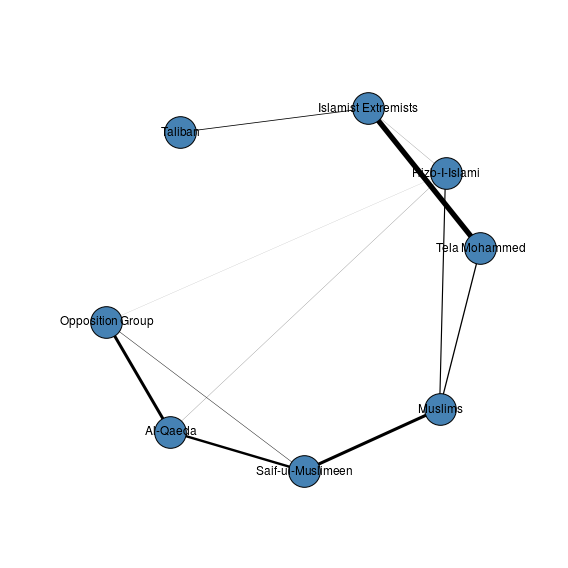

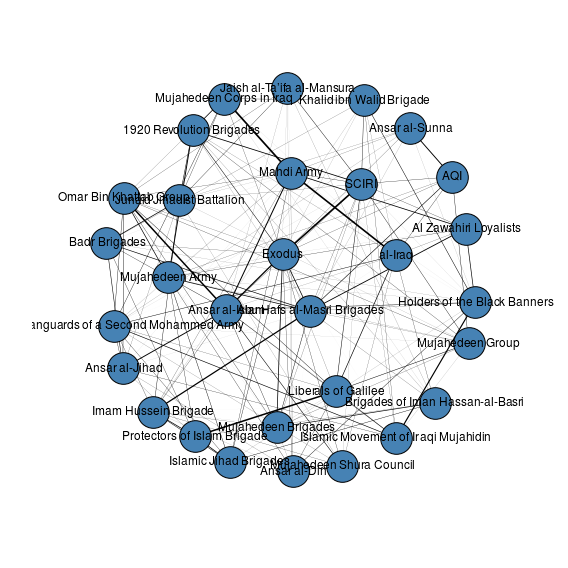

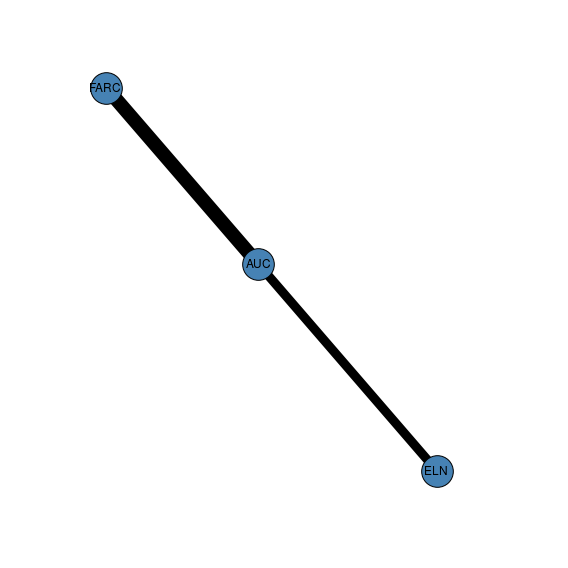

In [2]:
node_trans = pd.read_csv('../../data/group_names_trans.csv')
node_trans['nx_name'] = node_trans.AbmGTDname.apply(name_cleaner)

for country in ['Afghanistan', 'Iraq', 'Colombia']:
    #Load the multihawkes results
    multi = json.load( open('../../results/multihawkes/r1000_data/v1/%s_multihawkes.json' % country) )
    #Get the names
    temp = pd.read_csv('../../data/%s_multihawkes_data.csv' % country, index_col=0)
    names = temp.iloc[:, 1:].columns.values.tolist()
    #recreate the network
    edges = []
    for gname in names:
        for i, w in enumerate(multi[gname]['W']):
            if w!=0:
                edges.append([name_cleaner(gname), name_cleaner(names[i]), w])
    #Write the network
    with open('../../results/multihawkes/r1000/%s_edges.csv' % country, 'w') as wfile:
        print('Source,Target,Weight', file=wfile)
        for i,j,w in edges:
            print('%s,%s,%f' % (i, j, w), file=wfile)
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    #Create the nodelist
    nodelist = set(node_trans[node_trans.country_txt == country].nx_name.values.tolist()).intersection(G.nodes())
    #Subset the graph
    sG = G.subgraph(nodelist)
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    weights = [sG[u][v]['weight']*5 for u,v in sG.edges()]
    pos = nx.spring_layout(sG)
    nx.draw(sG, pos=pos, node_size=1000, 
            nodelist = nodelist, 
            arrows=True, 
            arrowstyle='>', with_labels=True, 
            node_color='steelblue', width=weights, ax=ax)
    plt.tight_layout()
    plt.savefig('../../results/multihawkes/r1000/%s.eps' % country)
    plt.savefig('../../results/multihawkes/r1000/%s.png' % country)

In [2]:
pd.read_csv('../../results/multihawkes/r1000/Afghanistan_edges.csv').columns

Index(['Source', 'Target', 'Weight'], dtype='object')

In [3]:
countries = ['Afghanistan', 'Iraq', 'Colombia']
hawkes_edges = {c:pd.read_csv('../../results/multihawkes/r1000/%s_edges.csv' % c) for c in countries}

In [4]:
known_edges = {c:pd.read_csv('../../data/%s_edges.csv' % c) for c in countries}

In [5]:
hawkes_edges['Colombia']

,Source,Target,Weight
0,Gunmen,Left-Wing Extremists,0.217823
1,Left-Wing Extremists,Rebels,0.030998
2,Left-Wing Extremists,Unknown,0.131858
3,ELN,Gunmen,0.062967
4,ELN,FARC,0.476880
5,ERP,Rebels,0.085986
6,Rebels,Left-Wing Guerrillas,0.063542
7,AUC,ELN,1.115455
8,AUC,Rebels,0.049256
9,AUC,FARC,2.026551


In [6]:
known_edges['Colombia']

,Source,Target
0,Revolutionary Armed Forces of Colombia (FARC),National Liberation Army of Colombia (ELN)
1,Revolutionary Armed Forces of Colombia (FARC),United Self Defense Units of Colombia (AUC)
2,Revolutionary Armed Forces of Colombia (FARC),United Self Defense Units of Colombia (AUC)
3,National Liberation Army of Colombia (ELN),United Self Defense Units of Colombia (AUC)
4,National Liberation Army of Colombia (ELN),Popular Liberation Army (EPL)


In [7]:
def name_reverser(x, name_trans):
    try:
        return name_trans[name_trans.nxName == x].AbmGTDname.values.tolist()[0]
    except:
        return x
        

name_trans = pd.read_csv('../../data/group_names_trans.csv')
name_trans['nxName'] = name_trans.AbmGTDname.apply(name_cleaner)

hawkes_edges['Colombia']['Source'] = hawkes_edges['Colombia'].Source.apply(lambda x: name_reverser(x, name_trans))
hawkes_edges['Colombia']['Target'] = hawkes_edges['Colombia'].Target.apply(lambda x: name_reverser(x, name_trans))

In [8]:
hawkes_graphs = {}
known_graphs = {}
hawkes_table = []
known_table = []
for country in countries:
    #Hawkes num
    hawkes_graphs[country] = nx.Graph()
    hawkes_graphs[country].add_edges_from( hawkes_edges[country].iloc[:, :2].values.tolist() )
    #known num
    known_graphs[country] = nx.Graph()
    known_graphs[country].add_edges_from( known_edges[country].values.tolist() )
    #Pull the degree
    for node in hawkes_graphs[country].nodes():
        hawkes_table.append([country, node, hawkes_graphs[country].degree[node]])
    for node in known_graphs[country].nodes():
        known_table.append([country, node, known_graphs[country].degree[node]])

In [9]:
hdf = pd.DataFrame(hawkes_table, columns = ['Country', 'Node', 'hDegree'])
kdf = pd.DataFrame(known_table, columns = ['Country', 'Node', 'kDegree'])

for c in countries:
    hsum = hdf[hdf.Country == c].hDegree.sum()
    ksum = kdf[kdf.Country == c].kDegree.sum()
    print(c, hsum, ksum, (hsum/ksum)/len(known_graphs[c].nodes()) )

Afghanistan 10 4 0.833333333333
Iraq 506 10 10.12
Colombia 28 8 0.875


In [10]:
pd.merge(hdf, kdf, on=['Country', 'Node'])

,Country,Node,hDegree,kDegree
0,Afghanistan,Taliban,4,2
1,Afghanistan,Al-Qaeda,2,1
2,Iraq,Ansar al-Islam,18,2
3,Iraq,Mujahedeen Shura Council,16,2
4,Iraq,Ansar al-Sunna,12,2
5,Iraq,Islamic Jihad Brigades,17,1
6,Iraq,AQI,13,3
7,Colombia,United Self Defense Units of Colombia (AUC),6,2
8,Colombia,Revolutionary Armed Forces of Colombia (FARC),3,2
9,Colombia,National Liberation Army of Colombia (ELN),3,3


In [27]:
for country in countries:
    #Hawkes graph
    hawkes_G = nx.Graph()
    hawkes_G.add_edges_from( hawkes_edges[country].iloc[:,:2].values.tolist() )
    #allied graph
    known_edges[country]['Weight']=1
    known_G = nx.Graph()
    known_G.add_edges_from( known_edges[country].iloc[:, :2].values.tolist() )
    #Graph intersection
    full_graph = nx.compose(hawkes_G, known_G)
    #Add in disconnected nodes
#     mudf = pd.read_csv('../../data/%s_mus.csv' % country)
#     for gname in mudf.gname.values.tolist():
#         if gname not in full_graph.nodes():
#             hawkes_G.add_node(gname)
#             hawkes_G.add_edge(gname, gname)
    #Subset it
    sub_full = hawkes_G.subgraph(name_trans.gname.values.tolist())
    print(country, sum(x for k,x in sub_full.degree() if k in known_G.nodes())/sum(x for k,x in known_G.degree()))

Afghanistan 1.25
Iraq 5.8
Colombia 1.0


In [21]:
for country in countries:
    #Hawkes graph
    hawkes_G = nx.Graph()
    hawkes_G.add_weighted_edges_from( hawkes_edges[country].values.tolist() )
    #allied graph
    known_edges[country]['Weight']=1
    known_G = nx.Graph()
    known_G.add_weighted_edges_from( known_edges[country].values.tolist() )
    #Graph intersection
    full_graph = nx.compose(hawkes_G, known_G)
    #Add in disconnected nodes
#     mudf = pd.read_csv('../../data/%s_mus.csv' % country)
#     for gname in mudf.gname.values.tolist():
#         if gname not in full_graph.nodes():
#             hawkes_G.add_node(gname)
#             hawkes_G.add_edge(gname, gname)
    #Subset it
    sub_full = hawkes_G.subgraph(name_trans.gname.values.tolist())
    print(country, sum(x for k,x in sub_full.degree())/sum(x for k,x in known_G.degree()))
    #Plot it out
#     if country == 'Iraq':
#         fig=plt.figure(figsize=(10,10))
#     else:
#         fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(111)
#     edge_coloring, edge_widths = [], []
#     for edge in sub_full.edges():
#         if edge in known_G.edges():
#             edge_coloring.append('darkred')
#             edge_widths.append(2)
#         else:
#             edge_coloring.append('gray')
#             edge_widths.append(1)
#     node_labels = {n:name_cleaner(n) for n in sub_full.nodes()}
#     pos = nx.spring_layout(sub_full, scale=0.8)
#     nx.draw(sub_full, pos=pos, node_size=1000, 
#             with_labels=True, edge_color = edge_coloring, width = edge_widths, labels=node_labels,
#             node_color='steelblue', ax=ax)
#     plt.tight_layout()
#     plt.savefig('../../results/multihawkes/r1000/%s_intersection.eps' % country)
#     plt.savefig('../../results/multihawkes/r1000/%s_intersection.png' % country)

Afghanistan 1.5
Iraq 30.6
Colombia 1.0


In [24]:
sub_full.edges()

EdgeView([('Revolutionary Armed Forces of Colombia (FARC)', 'United Self Defense Units of Colombia (AUC)'), ('Revolutionary Armed Forces of Colombia (FARC)', 'National Liberation Army of Colombia (ELN)'), ('United Self Defense Units of Colombia (AUC)', 'United Self Defense Units of Colombia (AUC)'), ('United Self Defense Units of Colombia (AUC)', 'National Liberation Army of Colombia (ELN)')])